In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [3]:
# train=train.drop_duplicates(keep='first')
# test=test.drop_duplicates(keep='first')

## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

In [4]:
tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

In [5]:
tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

In [6]:
train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

In [7]:
train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

In [8]:
level = 85

In [9]:
train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

In [10]:
train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

- 1차원으로 합치기

In [11]:
not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

In [12]:
train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

- 전용면적별세대수 채우기

In [13]:
for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

In [14]:
sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

In [15]:
sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

In [16]:
sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

In [17]:
sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 7) 대형전용면적 총개수

In [18]:
sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

In [19]:
sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

In [20]:
col = ['단지명','도로명주소','subway_name','임대상가']

In [21]:
train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

## 2. 데이터 나누기: 단지내주차면수 987 기준

In [49]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

In [50]:
test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

### 1) train/test up : area 변수 추가(Baseline추가 MSE:96)

In [51]:
tmp = train[train['단지내주차면수']>=1162].reset_index(drop=True)
tmp['등록차량수-총세대수'] = tmp.apply(lambda x : x['등록차량수']-x['총세대수'],axis=1)
tmp['cluster'] = tmp.apply(lambda x : 1 if x['등록차량수-총세대수']>0 else 0 ,axis=1)

<AxesSubplot:xlabel='등록차량수-총세대수', ylabel='Density'>

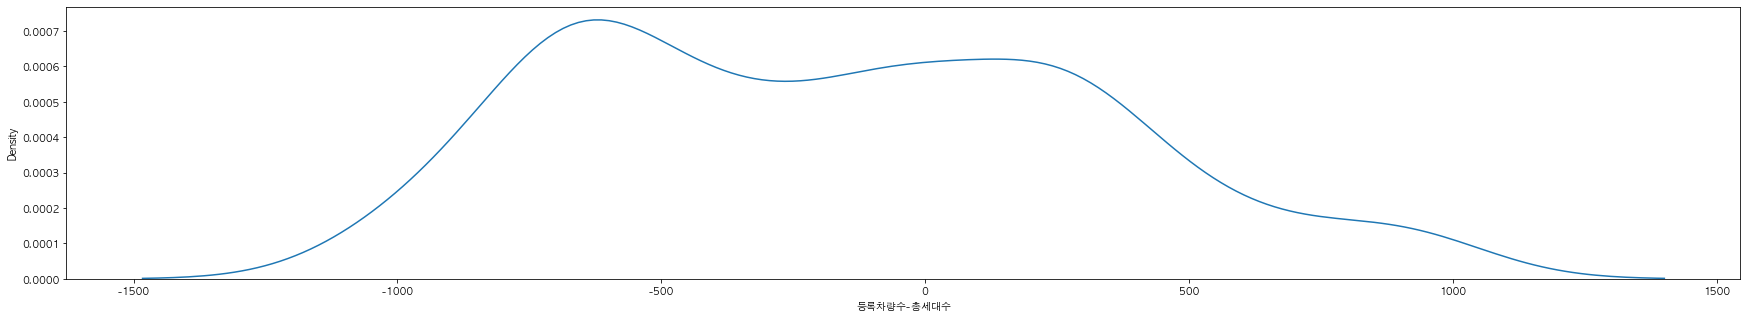

In [52]:
fig, ax = plt.subplots(figsize=(30,5))
sns.kdeplot(data=tmp,x='등록차량수-총세대수')

<AxesSubplot:xlabel='지역', ylabel='count'>

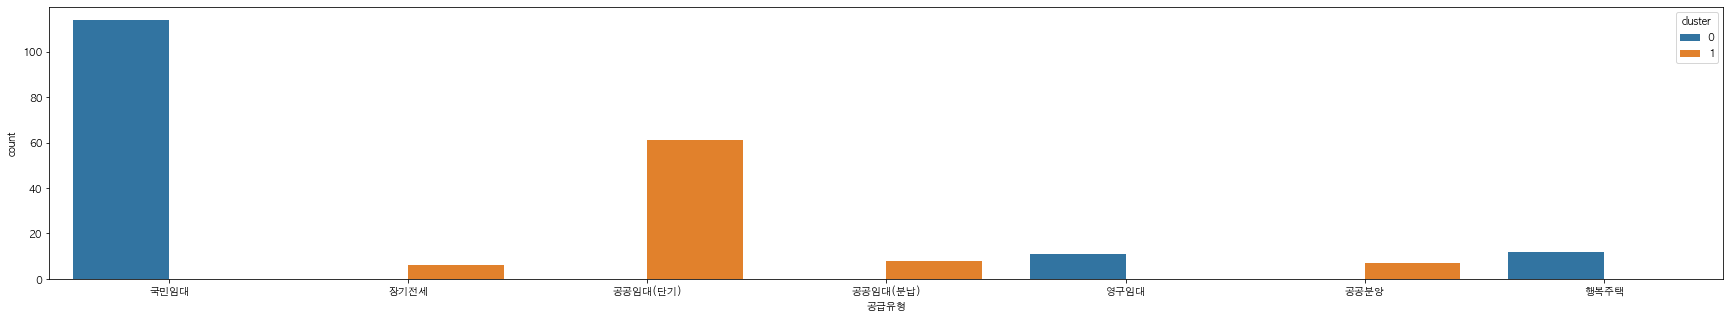

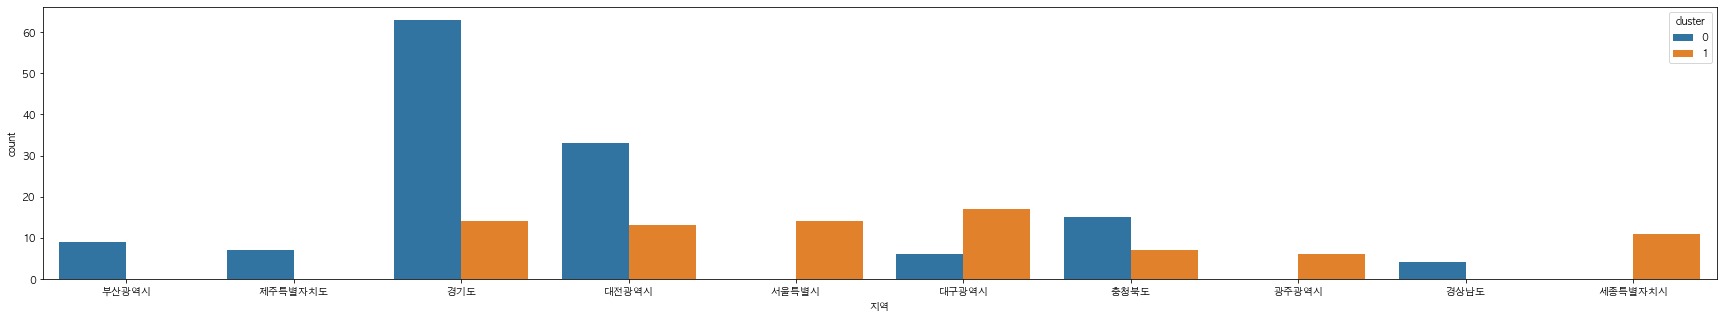

In [53]:
tmp = tmp[(tmp['등록차량수-총세대수']>200)|(tmp['등록차량수-총세대수']<-200)]
fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='공급유형',hue='cluster')

fig, ax = plt.subplots(figsize=(30,5))
sns.countplot(data=tmp,x='지역',hue='cluster')

In [54]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [55]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

In [56]:
train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

### 2) 각 변수 소수점 4째자리까지 반올림

In [57]:
col_up = [i for i in test_up.columns if train_up[i].dtype == 'float64']   
col_down = [i for i in test_down.columns if train_down[i].dtype == 'float64']   

In [58]:
def round_func(df,col):
    for i in col:
        df[col] = df[col].apply(lambda x : round(x,4))

In [59]:
round_func(train_down,col_down)
round_func(train_up,col_up)

In [60]:
round_func(test_down,col_down)
round_func(test_up,col_up)

## 3. 모델링

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [62]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

### 1) train/test down

In [63]:
X = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X = pd.get_dummies(X, drop_first=True) #지역
y = train_down['등록차량수']

In [64]:
models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_down,pred_down,error_down = fit_models(X, y, models, cv=True)
print('MAE : ',error_down)

MAE :  106.76906486224456


<AxesSubplot:>

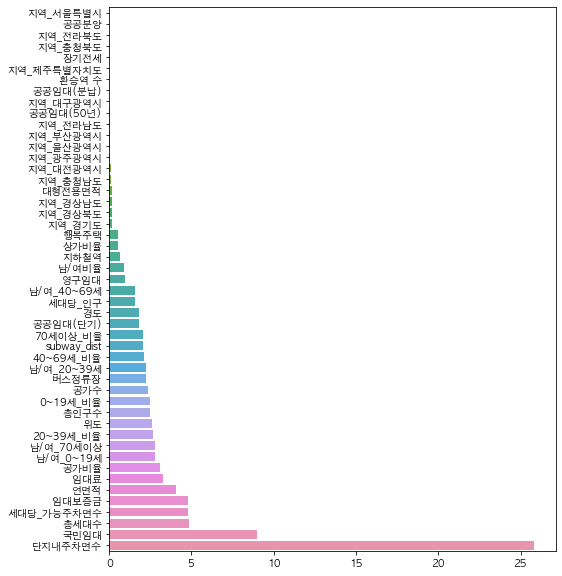

In [65]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_down.feature_importances_)], x = list(model_down.feature_importances_[np.argsort(model_down.feature_importances_)]))

### 2) train/test up

In [66]:
X = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
y = train_up['등록차량수']

models = [CatBoostRegressor(random_state=2021, loss_function = 'MAE')]

model_up,pred_up,error_up = fit_models(X, y, models, cv=True)
print('MAE : ',error_up)

MAE :  293.8326340239597


<AxesSubplot:>

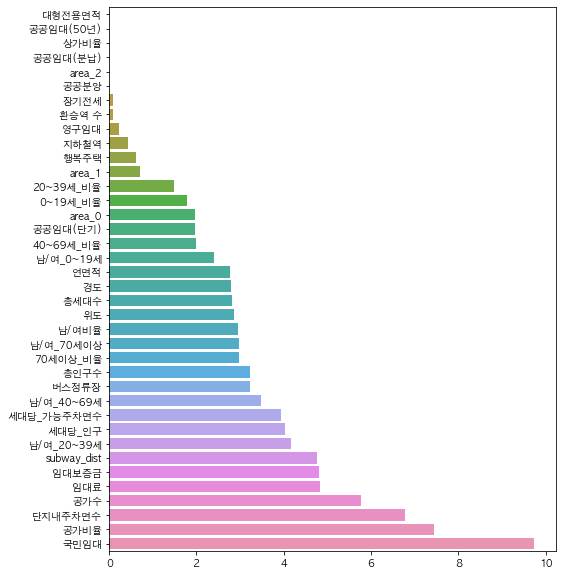

In [67]:
plt.figure(figsize=(8,10))
sns.barplot(y = X.columns[np.argsort(model_up.feature_importances_)], x = list(model_up.feature_importances_[np.argsort(model_up.feature_importances_)]))

In [68]:
best_tst_pred1 = pred_down
best_tst_pred2 = pred_up


In [69]:
train_up.columns

Index(['단지코드', '총세대수', '지역', '공가수', '지하철역', '버스정류장', '단지내주차면수', '등록차량수', '연면적',
       '위도', '경도', 'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율',
       '남/여_0~19세', '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율',
       '20~39세_비율', '40~69세_비율', '70세이상_비율', '상가비율', '세대당_가능주차면수', '공가비율',
       '국민임대', '공공임대(50년)', '영구임대', '공공임대(단기)', '공공임대(분납)', '장기전세', '공공분양',
       '행복주택', '임대료', '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2'],
      dtype='object')

In [95]:
col = ["단지코드","국민임대","공가비율","단지내주차면수","공가수","임대료","임대보증금","subway_dist","남/여_20~39세","세대당_인구","세대당_가능주차면수","남/여_40~69세","버스정류장","총인구수","총세대수"]
tst_pred1 = pd.merge(pd.DataFrame(best_tst_pred1,index=[0]).T.reset_index(),
         pd.DataFrame(train_down[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred2 = pd.merge(pd.DataFrame(best_tst_pred2,index=[0]).T.reset_index(),
         pd.DataFrame(train_up[col].reset_index(drop=True)).reset_index(),
         on="index")

tst_pred1 = pd.merge(tst_pred1, pd.concat([train_down.단지코드,train_down['등록차량수']],axis=1), on = "단지코드")
tst_pred2 = pd.merge(tst_pred2, pd.concat([train_up.단지코드,train_up['등록차량수']],axis=1), on = "단지코드")

tst_pred1["diff"] = tst_pred1["등록차량수"]-tst_pred1[0]
tst_pred2["diff"] = tst_pred2["등록차량수"]-tst_pred2[0]

q = list(tst_pred1["단지내주차면수"].quantile([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]))
print(q)

q2 = list(tst_pred2["단지내주차면수"].quantile([0,.2,.4,.6,.8,1]))
print(q2)

tst_pred1["realclass"] = [99]*len(tst_pred1)
for i in range(len(q[:-1])):
    tst_pred1.loc[(tst_pred1.단지내주차면수>=q[i])&(tst_pred1.단지내주차면수<q[i+1]),"realclass"] = i
tst_pred1.loc[tst_pred1.단지내주차면수==q[9],"realclass"] = 9

tst_pred1["predclass"] = [99]*len(tst_pred1)
for i in range(len(q[:-1])):
    tst_pred1.loc[(tst_pred1[0]>=q[i])&(tst_pred1[0]<q[i+1]),"predclass"] = i
tst_pred1.loc[tst_pred1[0]==q[9],"predclass"] = 9

tst_pred2["realclass"] = [99]*len(tst_pred2)
for i in range(len(q2[:-1])):
    tst_pred2.loc[(tst_pred2.단지내주차면수>=q2[i])&(tst_pred2.단지내주차면수<q2[i+1]),"realclass"] = i
tst_pred2.loc[tst_pred2.단지내주차면수==q2[5],"realclass"] = 4

tst_pred2["predclass"] = [99]*len(tst_pred2)
for i in range(len(q2[:-1])):
    tst_pred2.loc[(tst_pred2[0]>=q2[i])&(tst_pred2[0]<q2[i+1]),"predclass"] = i
tst_pred2.loc[tst_pred1[0]==q2[5],"predclass"] = 4

from sklearn.metrics import confusion_matrix as cm 
print(cm(tst_pred1.realclass,tst_pred1.predclass))
print(cm(tst_pred2.realclass,tst_pred2.predclass))

[13.0, 166.1, 249.8, 329.29999999999995, 393.0, 451.5, 530.0, 633.0999999999999, 730.4000000000001, 856.6000000000001, 986.0]
[988.0, 1069.2, 1162.8000000000002, 1291.6, 1528.2000000000003, 1798.0]
[[30  7  0  0  0  0  0  0  0  0  0]
 [ 6 15 14  1  0  0  0  0  0  0  0]
 [ 1  4 23  7  1  0  0  0  0  0  0]
 [ 0  2  6 18  6  3  0  0  0  0  0]
 [ 0  1  1  4 13 17  1  0  0  0  0]
 [ 0  0  0  1  1 20 11  1  1  0  0]
 [ 0  0  0  0  1  5 19 11  1  0  0]
 [ 0  0  0  0  0  2  9 20  5  0  0]
 [ 0  0  0  1  0  0  8 12 14  0  1]
 [ 0  0  0  0  0  0  1  6 24  3  1]
 [ 0  0  0  0  0  0  0  0  0  2  0]]
[[1 4 2 2 0 2]
 [2 4 1 0 1 2]
 [1 2 2 2 1 2]
 [3 1 2 3 0 1]
 [0 3 2 2 3 1]
 [0 0 0 0 0 0]]


In [96]:
tst_pred2.columns

Index([      'index',             0,        '단지코드',        '국민임대',
              '공가비율',     '단지내주차면수',         '공가수',         '임대료',
             '임대보증금', 'subway_dist',  '남/여_20~39세',      '세대당_인구',
        '세대당_가능주차면수',  '남/여_40~69세',       '버스정류장',        '총인구수',
              '총세대수',       '등록차량수',        'diff',   'realclass',
         'predclass'],
      dtype='object')

In [97]:
tst_pred2 = tst_pred2[['index',  'diff',      '등록차량수',      0,        '단지코드',        '국민임대',
              '공가비율',     '단지내주차면수',         '공가수',         '임대료',
             '임대보증금', 'subway_dist',  '남/여_20~39세',      '세대당_인구',
        '세대당_가능주차면수',  '남/여_40~69세',       '버스정류장',        '총인구수', '총세대수',
            'realclass',   'predclass']]

In [100]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

tst_pred2.sort_values("diff")

,index,diff,등록차량수,0,단지코드,국민임대,공가비율,단지내주차면수,공가수,임대료,임대보증금,subway_dist,남/여_20~39세,세대당_인구,세대당_가능주차면수,남/여_40~69세,버스정류장,총인구수,총세대수,realclass,predclass
31,48,-749.386226,196.0,945.386226,C2362,0,0.0305,1055.0,46.0,100857.1429,2.391143e+07,0.0280,1.0127,2.4700,0.6991,1.0366,2.0,54252.0000,1509,0,99
16,31,-612.614063,922.0,1534.614063,C2393,1166,0.0006,1176.0,1.0,187753.0769,2.206062e+07,0.0059,0.9498,2.5400,0.7607,1.0144,2.0,31073.0000,1546,2,4
36,24,-591.732408,881.0,1472.732408,C1286,0,0.0294,988.0,27.0,571666.6667,3.290000e+07,0.1093,0.9506,2.3900,1.0751,1.0131,2.0,38423.0000,919,0,3
24,5,-584.061165,799.0,1383.061165,C2538,1473,0.0088,1299.0,13.0,288008.9474,3.086979e+07,0.0078,1.0021,2.5600,0.8819,0.9608,3.0,95543.0000,1473,3,3
47,30,-512.927567,579.0,1091.927567,C2377,1105,0.0199,1110.0,22.0,286911.6667,2.397550e+07,0.0253,0.9854,2.5200,1.0045,0.9796,3.0,120892.0000,1105,1,1
44,22,-393.382967,733.0,1126.382967,C1863,1099,0.0218,1154.0,24.0,161477.5000,2.005425e+07,0.3328,0.9527,2.4800,1.0500,1.0048,4.0,18361.0000,1099,1,1
26,17,-391.666469,1044.0,1435.666469,C1177,1668,0.0102,1756.0,17.0,188907.5000,2.942069e+07,0.0034,1.0457,2.0250,1.0528,0.9447,10.0,40387.5000,1668,4,3
10,50,-390.924588,619.0,1009.924588,C1176,1486,0.0370,1493.0,55.0,178850.0000,1.848075e+07,0.3012,1.0781,2.4850,1.0047,0.9611,3.0,47196.0000,1486,3,0
23,3,-285.845902,839.0,1124.845902,C1430,1533,0.0209,1296.0,32.0,183182.5000,3.146025e+07,0.0784,0.9417,2.6000,0.8454,0.9876,3.0,81775.0000,1533,3,1
41,39,-284.997788,783.0,1067.997788,C2618,1206,0.0258,1319.0,40.0,92976.0000,4.569760e+07,0.0407,1.0127,2.4700,0.8510,1.0366,7.0,54252.0000,1550,3,0


In [110]:
train[train.단지내주차면수>987].공급유형.value_counts()

국민임대        284
공공임대(단기)     90
행복주택         26
영구임대         14
공공임대(분납)      8
공공분양          7
장기전세          6
Name: 공급유형, dtype: int64

In [111]:
train[train.단지내주차면수>987].지역.value_counts()

경기도        174
대전광역시       57
광주광역시       33
충청북도        30
세종특별자치시     24
대구광역시       23
경상남도        23
전라남도        21
부산광역시       15
서울특별시       14
경상북도        10
제주특별자치도      7
전라북도         4
Name: 지역, dtype: int64

In [108]:
train[train.단지코드 == "C2362"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역,버스정류장,단지내주차면수,등록차량수,단지명,도로명주소,연면적,위도,경도,subway_name,subway_dist,환승역 수,총인구수,세대당_인구,남/여비율,남/여_0~19세,남/여_20~39세,남/여_40~69세,남/여_70세이상,0~19세_비율,20~39세_비율,40~69세_비율,70세이상_비율,상가비율,세대당_가능주차면수,공가비율,대형전용면적
2188,C2362,1509,아파트,경기도,행복주택,21.96,144,46.0,J,19760000.0,83000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2189,C2362,1509,아파트,경기도,행복주택,21.96,144,46.0,J,19760000.0,83000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2190,C2362,1509,아파트,경기도,행복주택,21.97,188,46.0,J,19760000.0,83000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2191,C2362,1509,아파트,경기도,행복주택,21.98,36,46.0,J,19360000.0,82000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2192,C2362,1509,아파트,경기도,행복주택,21.99,24,46.0,J,19360000.0,82000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2193,C2362,1509,아파트,경기도,행복주택,26.85,48,46.0,J,23520000.0,99000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2194,C2362,1509,아파트,경기도,행복주택,26.85,48,46.0,J,23520000.0,99000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2195,C2362,1509,아파트,경기도,행복주택,26.86,382,46.0,J,23520000.0,99000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2196,C2362,1509,아파트,경기도,행복주택,26.90,8,46.0,J,23520000.0,99000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0
2197,C2362,1509,아파트,경기도,행복주택,26.90,40,46.0,J,23520000.0,99000.0,0.0,2.0,1055.0,196.0,양주옥정3단지,경기도 양주시 옥정서로 254,359.31,127.088494,37.835428,덕정역,0.02803,1,54252.0,2.47,1.01,2.282937,1.012661,1.036574,0.835947,0.248544,0.293003,0.402345,0.056109,0.0,0.699139,0.030484,0


In [103]:
train_up[["공가수","공가비율"]].describe()

,공가수,공가비율
count,52.000000,52.000000
mean,20.384615,0.015713
std,12.815667,0.010088
min,0.000000,0.000000
25%,10.000000,0.007775
50%,20.000000,0.014350
75%,29.000000,0.022550
max,55.000000,0.039400


In [104]:
X_test[["공가수","공가비율"]].describe()

,공가수,공가비율
count,19.000000,19.000000
mean,21.315789,0.016805
std,8.756284,0.006757
min,9.000000,0.006600
25%,15.000000,0.012350
50%,20.000000,0.016000
75%,25.500000,0.021250
max,36.000000,0.028200


## 4. Final prediction

In [71]:
X_train = train_down.drop(columns=['단지코드','등록차량수'],axis=1)
X_train = pd.get_dummies(X_train, drop_first=True) 
y_train = train_down['등록차량수']
X_test = test_down.drop(columns=['단지코드'],axis=1)
X_test = pd.get_dummies(X_test, drop_first=True) 
X_test['지역_서울특별시'] = 0

cb_down = CatBoostRegressor(random_state=2021, loss_function = 'MAE',verbose=False).fit(X_train,y_train)
pred_down = cb_down.predict(X_test)

In [72]:
X_train = train_up.drop(columns=['단지코드','등록차량수','지역'],axis=1)
y_train = train_up['등록차량수']
X_test = test_up.drop(columns=['단지코드','지역'],axis=1)

cb_up = CatBoostRegressor(random_state=2021, loss_function = 'MAE',verbose=False).fit(X_train,y_train)
pred_up = cb_up.predict(X_test)

In [73]:
def get_pred():
    res_down = pd.DataFrame()
    res_down['code'] = test_down['단지코드'].values
    res_down['num'] = pred_down
    res_up = pd.DataFrame()
    res_up['code'] = test_up['단지코드'].values
    res_up['num'] = pred_up 
    res = pd.concat([res_down,res_up],axis=0).reset_index(drop=True)
    return res_down, res_up, res

## 5. 기존 score와 비교 및 제출

In [74]:
def submit():
    res = get_pred()[2]
    res.loc[147,:] = ['C1327',0]
    res.loc[148,:] = ['C2335',0]
    res.loc[149,:] = ['C2675',0]
    return res

sub = submit()
sub.to_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result.csv",index=False)

In [76]:
def score(mse):
    score = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_"+str(mse)+".csv")
    score = pd.merge(score,get_pred()[2],on='code',how='inner')
    val = test_up['단지코드'].values
    score_up = score.loc[score['code'].isin(val),:]
    score_down = score.loc[-score['code'].isin(val),:] #y가 새롭게 예측
    mae = mean_absolute_error(score['num_x'],score['num_y'])
    mae_up = mean_absolute_error(score_up['num_x'],score_up['num_y'])
    mae_down = mean_absolute_error(score_down['num_x'],score_down['num_y'])
    print('전체 MAE : ',mae)
    print('큰 영역 MAE : ',mae_up)
    print('작은 영역 MAE : ',mae_down)
    return score

In [77]:
res1 = score(98)

전체 MAE :  36.1424337016583
큰 영역 MAE :  61.73847990500765
작은 영역 MAE :  32.343020593348626


In [78]:
res2 = score(96)

전체 MAE :  32.92381044248713
큰 영역 MAE :  36.836499952472856
작은 영역 MAE :  32.343020593348626


In [79]:
tmp = pd.merge(res1,res2[['code','num_x']],on='code')
tmp.columns = ['code','98','current','96']

In [80]:
tmp

,code,98,current,96
0,C1072,751.540951,760.245559,751.540951
1,C1128,1233.521669,1185.730409,1188.382634
2,C1456,539.409116,616.725294,539.409116
3,C1840,533.220234,509.677015,533.220234
4,C1332,1242.048005,1365.641383,1327.919226
...,...,...,...,...
142,C2456,241.911953,253.930455,241.911953
143,C1266,501.895826,529.815331,501.895826
144,C2152,68.167044,89.961805,68.167044
145,C1267,340.937514,436.134549,340.937514
